In [1]:
%cd ..

/Users/jason/repos/diffusion-motion-inbetweening


In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from utils.editing_util import get_keyframes_mask

/opt/homebrew/Caskroom/miniforge/base/envs/condmdi/lib/python3.9/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.stats import gaussian_kde
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
n_samples = 1
n_hml_features = 263
n_max_frames = 196

dummy_data = torch.ones((n_samples, n_hml_features, 1, n_max_frames))
dummy_lengths = torch.tensor([n_max_frames] * n_samples)

In [4]:
hml_sections = {
    "root_angular": (0, 1),
    "root_xz_vel": (1, 3),
    "root_y_pos": (3, 4),
}

last_idx = 4

# Local Joint Position w.r.t. Root
for i in range(1, 22):
    hml_sections[f"joint_pos_{i}"] = (last_idx, last_idx + 3)
    last_idx += 3

# Local Joint Quaternion Rotation w.r.t. Root
for i in range(1, 22):
    hml_sections[f"joint_rot_{i}"] = (last_idx, last_idx + 6)
    last_idx += 6

# Global Joint Velocity (including root)
for i in range(0, 22):
    hml_sections[f"joint_vel_{i}"] = (last_idx, last_idx + 3)
    last_idx += 3

hml_sections["contact"] = (last_idx, last_idx + 4)
last_idx += 4

assert last_idx == n_hml_features

In [11]:
def plot_masks(name, feat_mask, joint_mask=None):
    plt.figure(figsize=(16, 6))
    plt.suptitle(name)

    plt.subplot(1, 2, 1)
    sns.heatmap(feat_mask[0, :, 0, :].numpy(), cmap="viridis", cbar=False)
    plt.xlabel("Frames")
    plt.ylabel("Features")

    plt.subplot(1, 2, 2)
    if joint_mask is not None:
        sns.heatmap(joint_mask[0, :, 0, :].numpy(), cmap="viridis", cbar=False)
    plt.xlabel("Frames")
    plt.ylabel("Joints")
    plt.tight_layout()
    plt.show()

In [17]:
def plot_mask_sections(name, feat_mask):
    plt.figure(figsize=(25, 30))
    plt.title(name)
    sns.heatmap(feat_mask[0, :, 0, :].numpy(), cmap="viridis", cbar=False, linewidths=0.1, linecolor="black")

    for section_name, (start, end) in hml_sections.items():
        plt.axhline(start, color="red", linestyle="--", linewidth=1)
        plt.axhline(end, color="red", linestyle="--", linewidth=1)
        plt.text(-15, (start + end) / 2, section_name, color="red")

    plt.xlabel("Frames")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

Available `edit_mode`s:

- **benchmark_sparse** - keyframes are observed every `trans_length` frames, starting from the initial frame.

- **benchmark_clip** - the middle trans_length frames are generate, and the rest of the frames are observed keyframes.

- **lower_body** - lower body joints taken from input motion, upper body is generated.

- **pelvis** - pelvis trajectory is observed, rest of joints are generated.

- **right_wrist** - right wrist trajectory is observed, rest of joints are generated.

- **gmd_keyframes** - 5 keyframe observed randomly.

- **uncond** - no keyframes for unconditioned sampling.

- **pelvis_vr** - pelvis and VR joints trajectory are observed, rest of joints are generated.

- **pelvis_feet** - pelvis and feet trajectory are observed, rest of joints are generated.

- **random_frames** - randomly select the number of keyframes and their placement; intended for training.

- **random_joints** - joints and keyframes are sampled randomly; intended for training.

- **random** - features, joints, and keyframes are sampled randomly; intended for training.

## `random_frames`

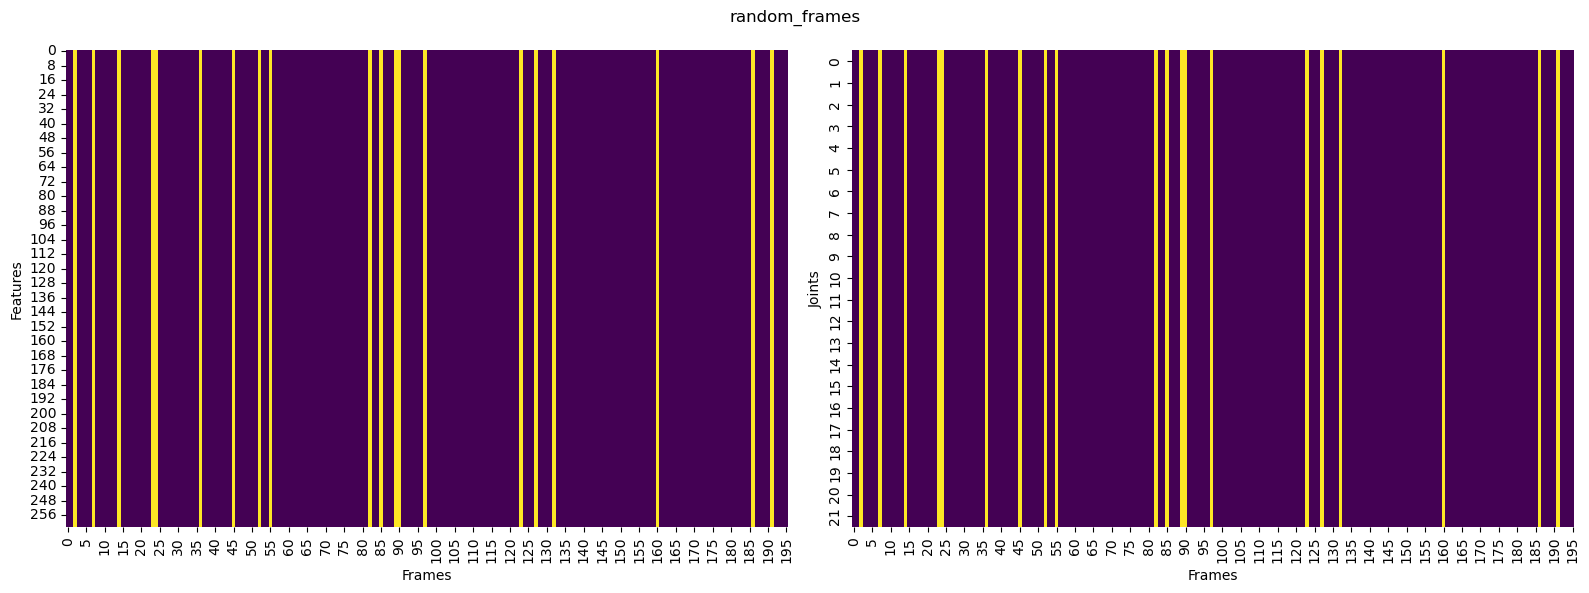

In [18]:
mode = "random_frames"

feat_mask, joint_mask = get_keyframes_mask(
    data=dummy_data,
    lengths=dummy_lengths,
    edit_mode=mode,
    get_joint_mask=True,
)

plot_masks(mode, feat_mask, joint_mask)

## `random_joints`

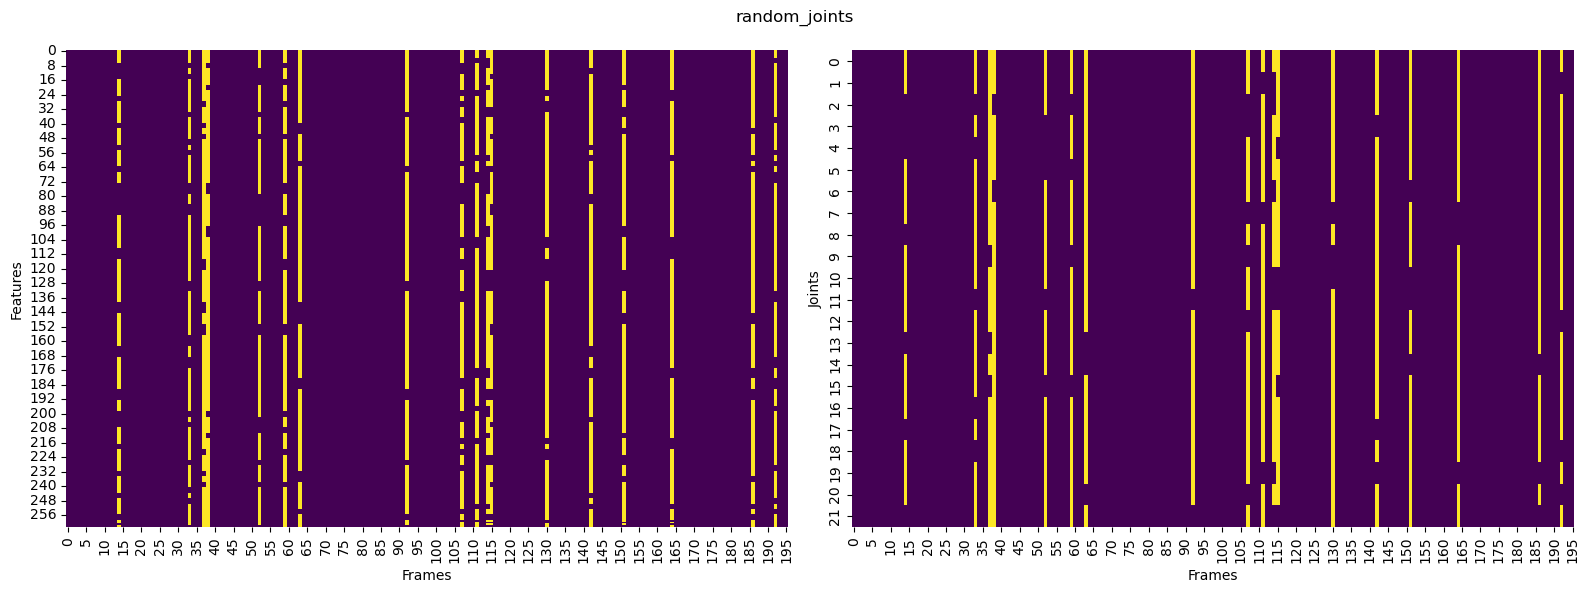

In [19]:
mode = "random_joints"

feat_mask, joint_mask = get_keyframes_mask(
    data=dummy_data,
    lengths=dummy_lengths,
    edit_mode=mode,
    get_joint_mask=True,
)

plot_masks(mode, feat_mask, joint_mask)

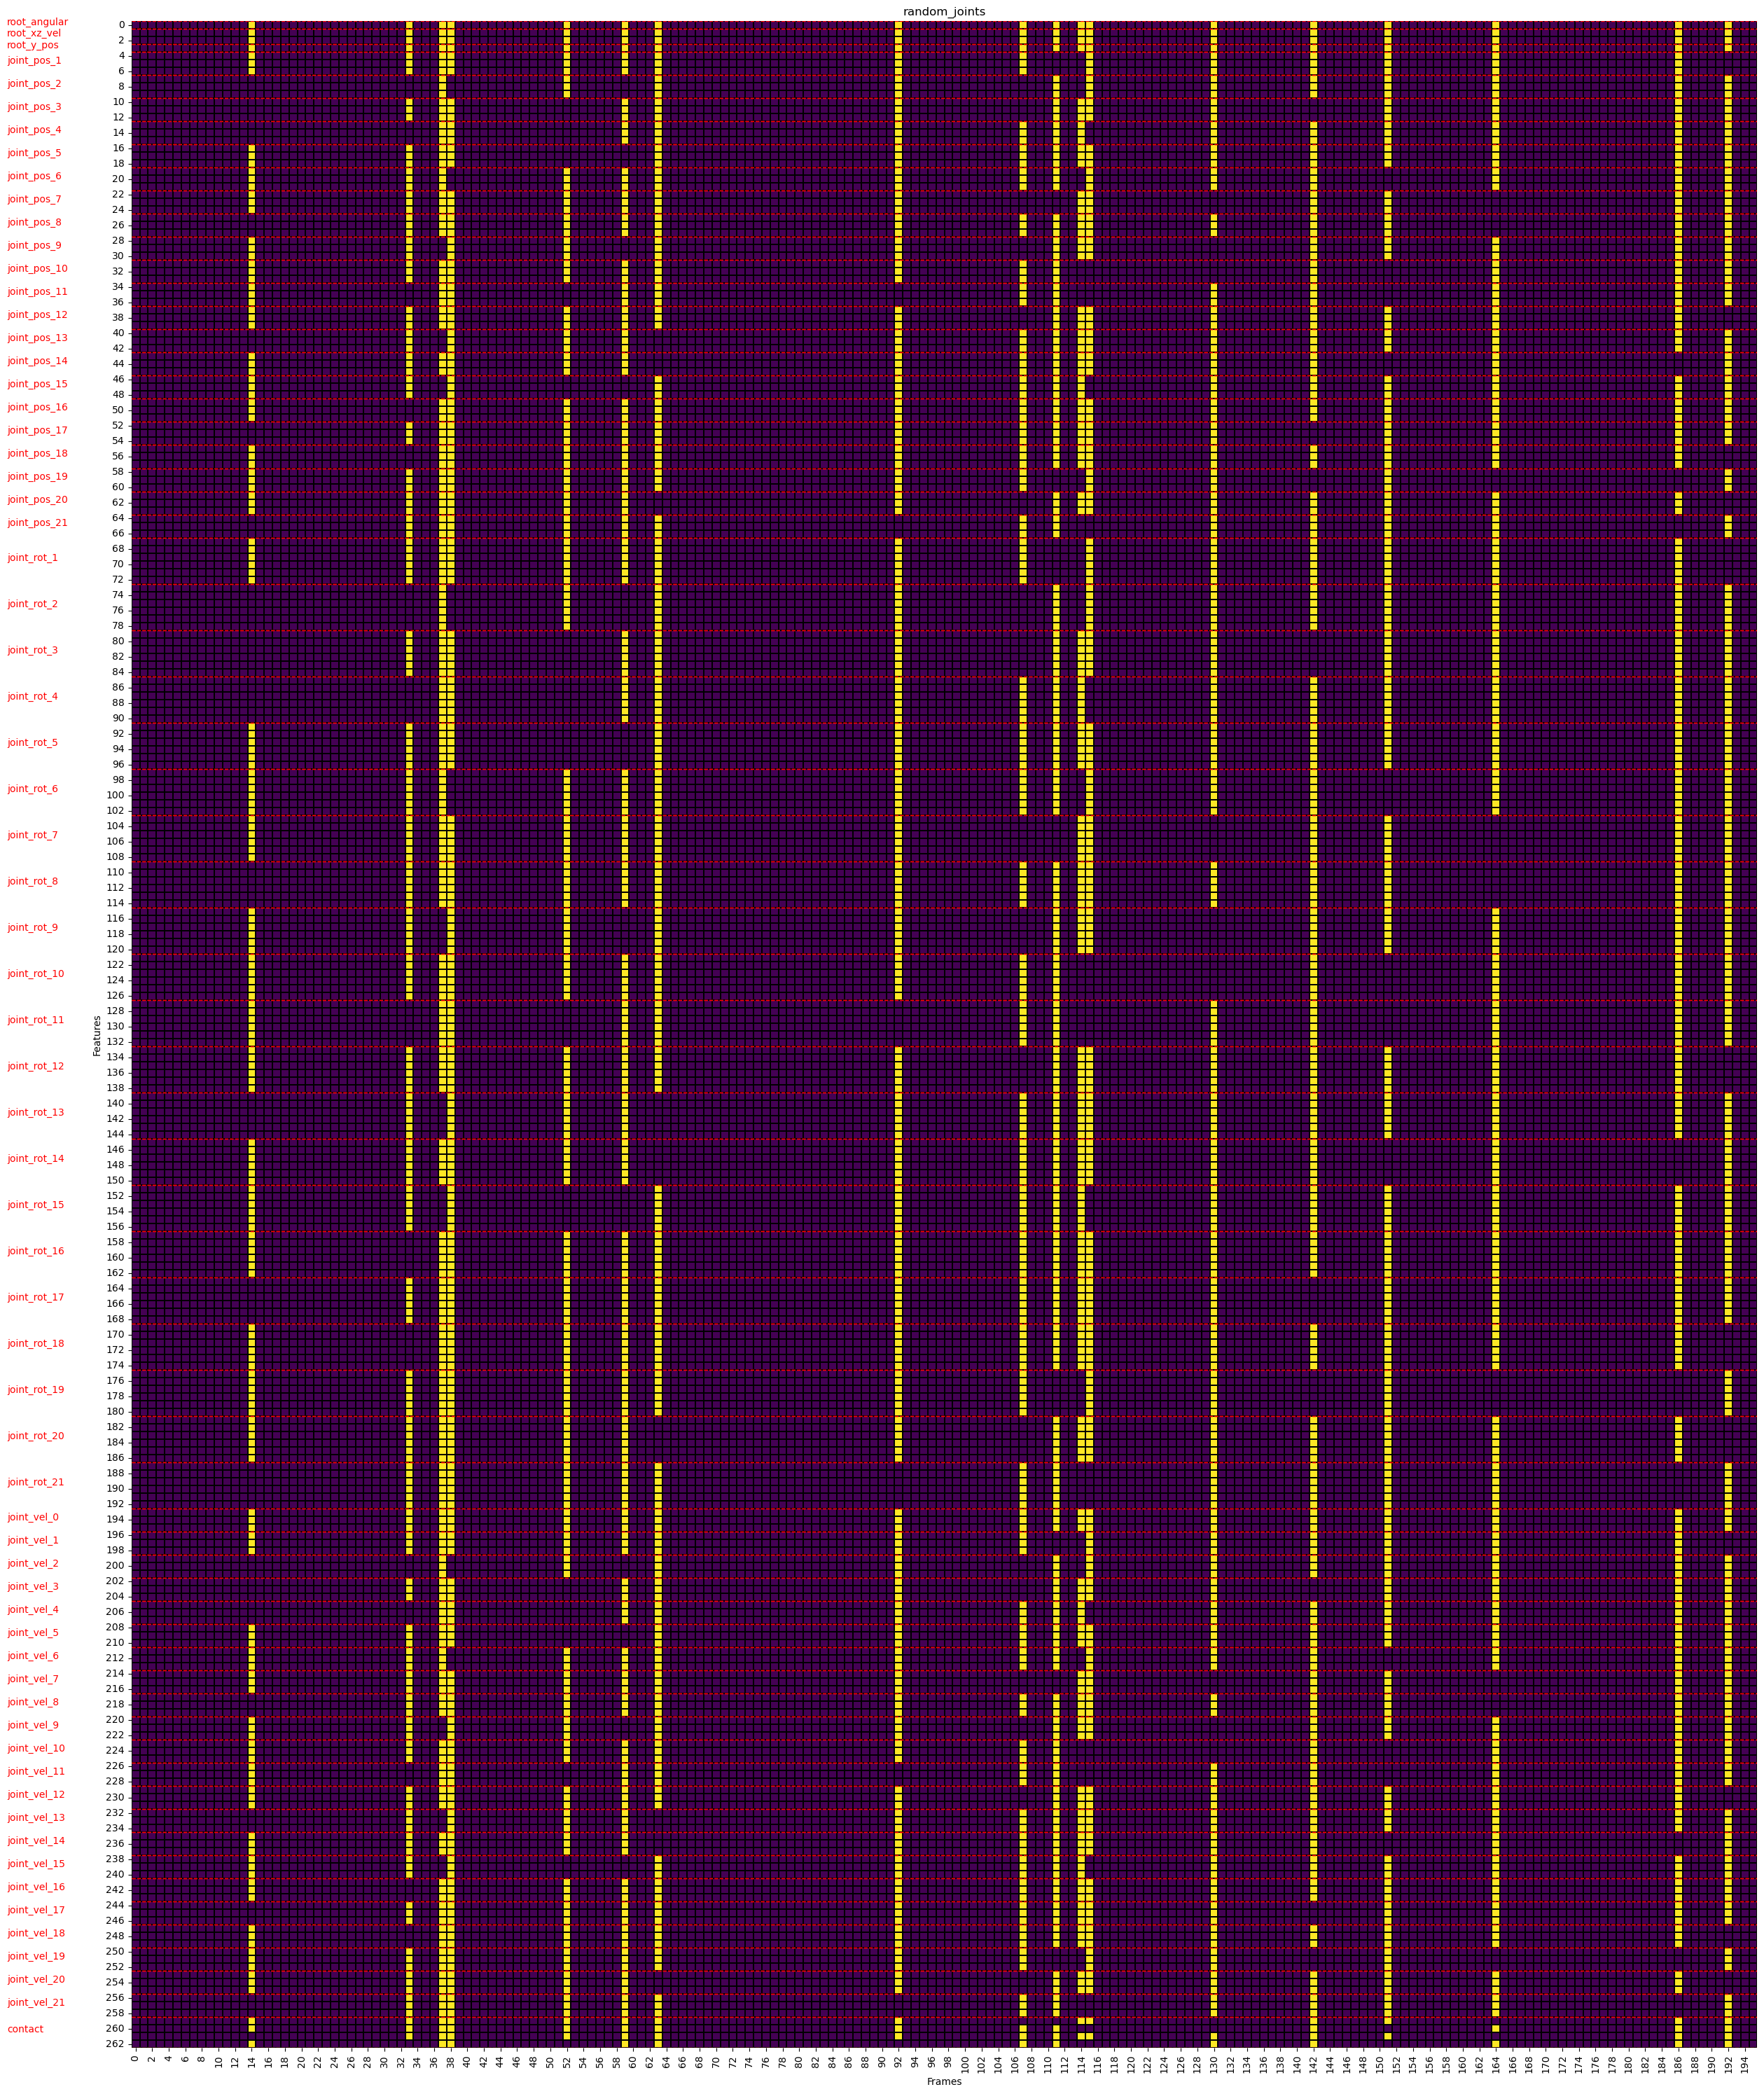

In [20]:
plot_mask_sections(mode, feat_mask)

## `random`

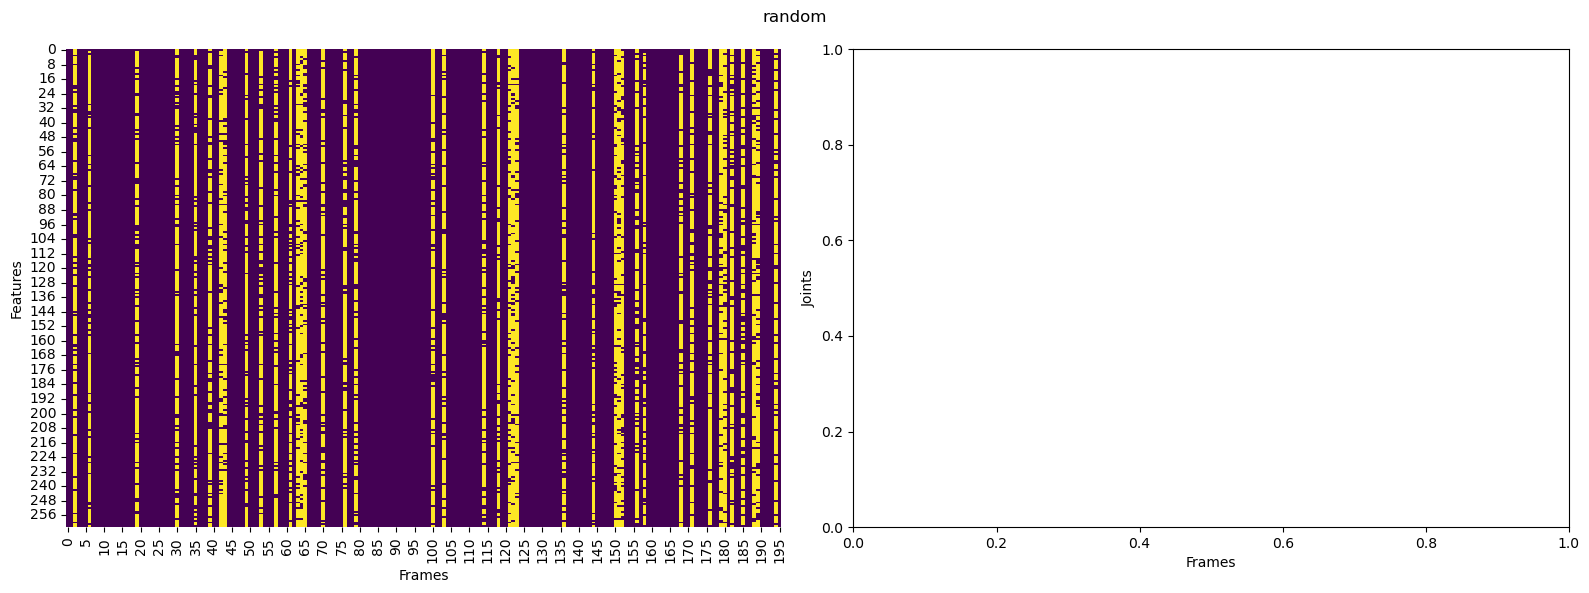

In [24]:
mode = "random"

feat_mask = get_keyframes_mask(
    data=dummy_data,
    lengths=dummy_lengths,
    edit_mode=mode,
    get_joint_mask=False,
)

plot_masks(mode, feat_mask)

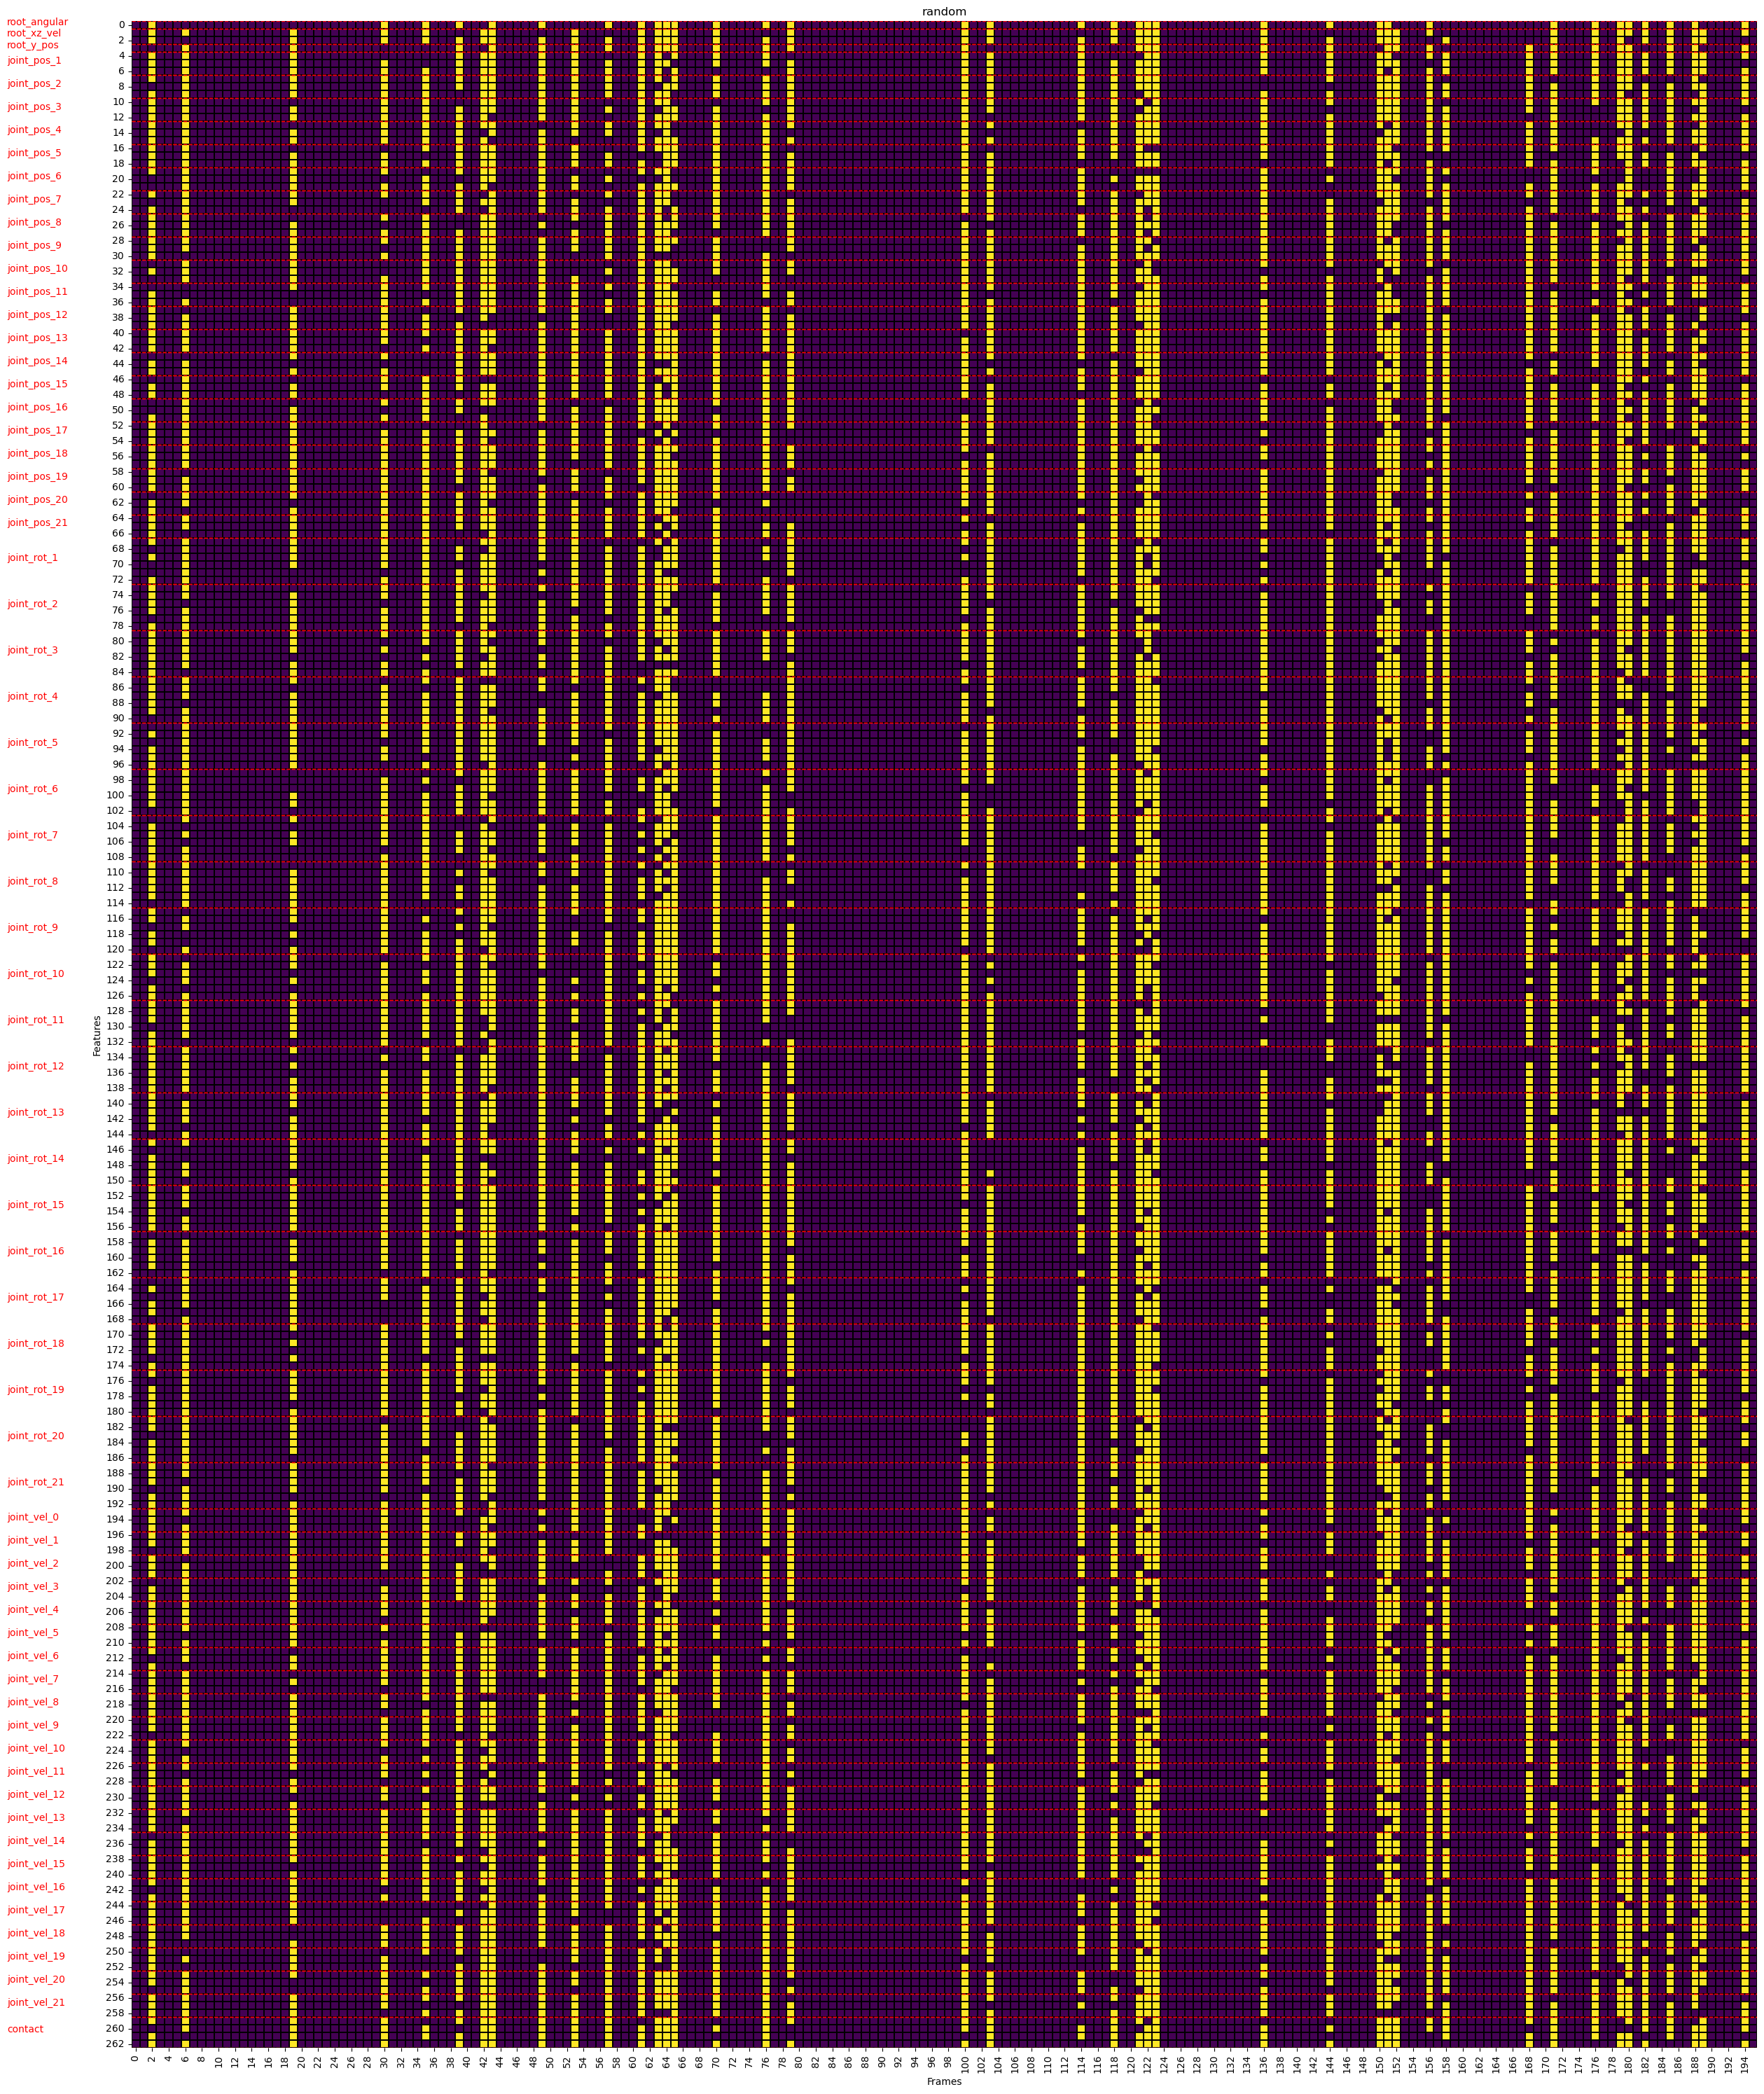

In [25]:
plot_mask_sections(mode, feat_mask)

---

## Overview of all edit modes

In [30]:
modes = [
    "benchmark_sparse",
    "benchmark_clip",
    "uncond",
    "right_wrist",
    "lower_body",
    "pelvis_feet",
    "pelvis_vr",
    "pelvis",
    "gmd_keyframes",
    "random_frames",
    "random_joints",
    "random",
]

mode_to_masks = {}

for mode in modes:
    out = get_keyframes_mask(
        data=dummy_data,
        lengths=dummy_lengths,
        edit_mode=mode,
        get_joint_mask=mode!="random",
    )

    if mode == "random":
        feat_mask = out
        mode_to_masks[mode] = (feat_mask, None)
    else:
        feat_mask, joint_mask = out
        mode_to_masks[mode] = (feat_mask, joint_mask)


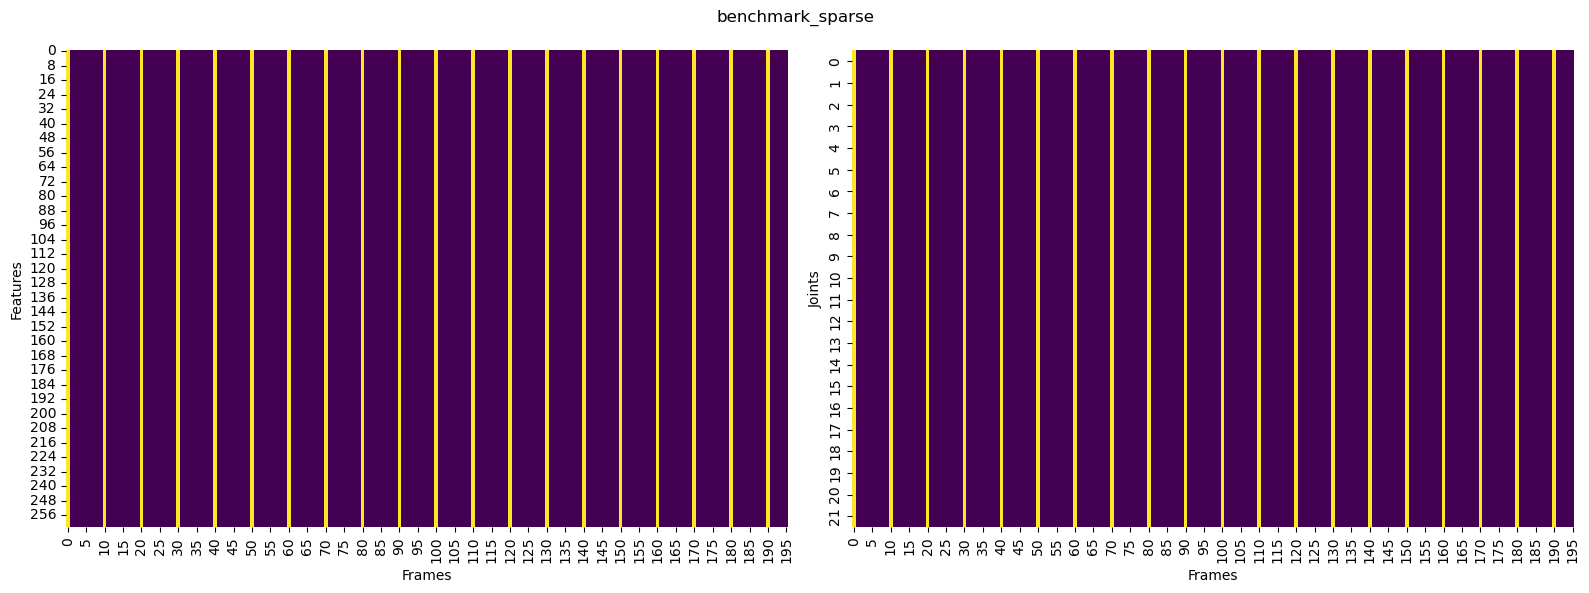

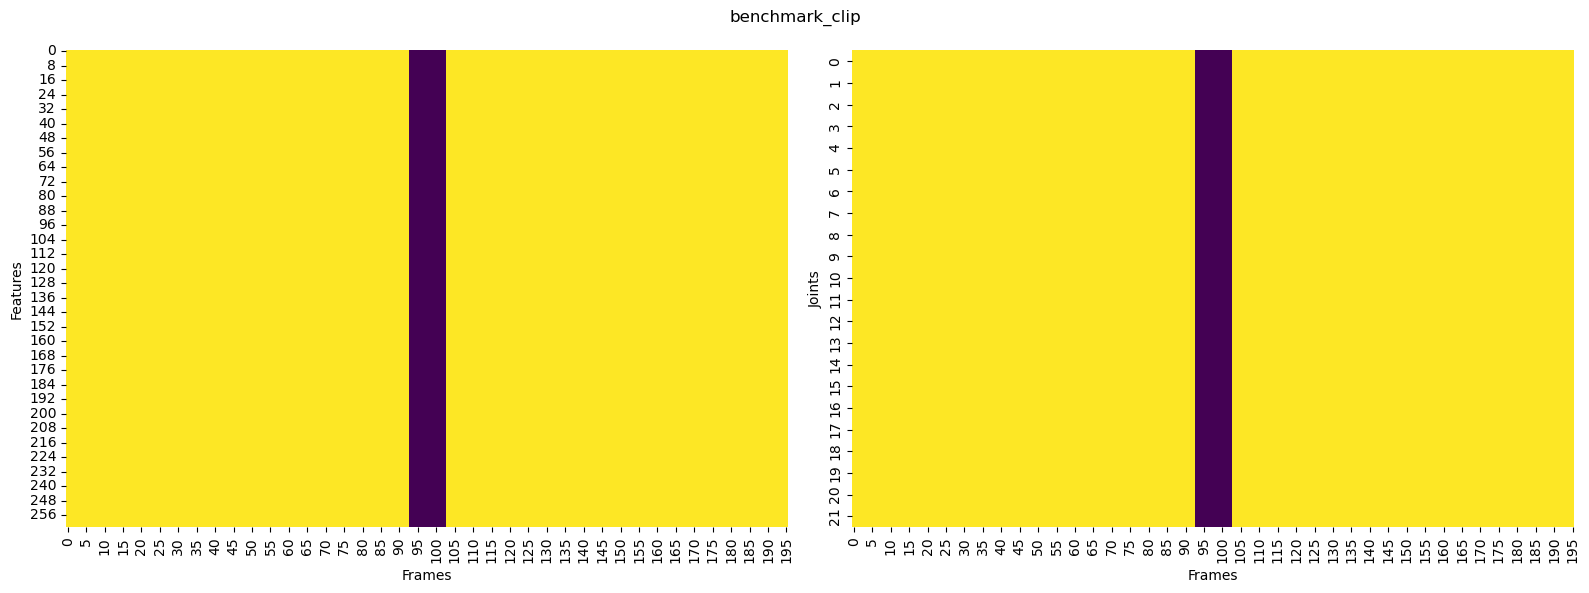

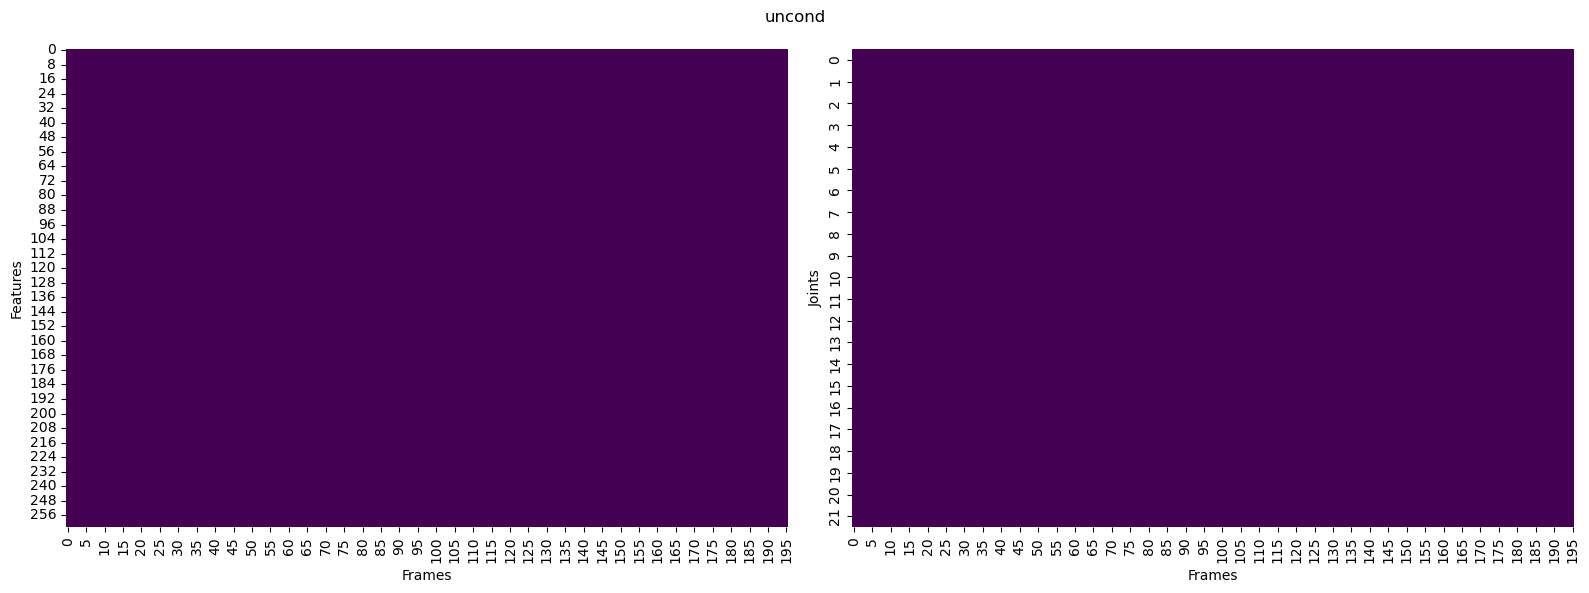

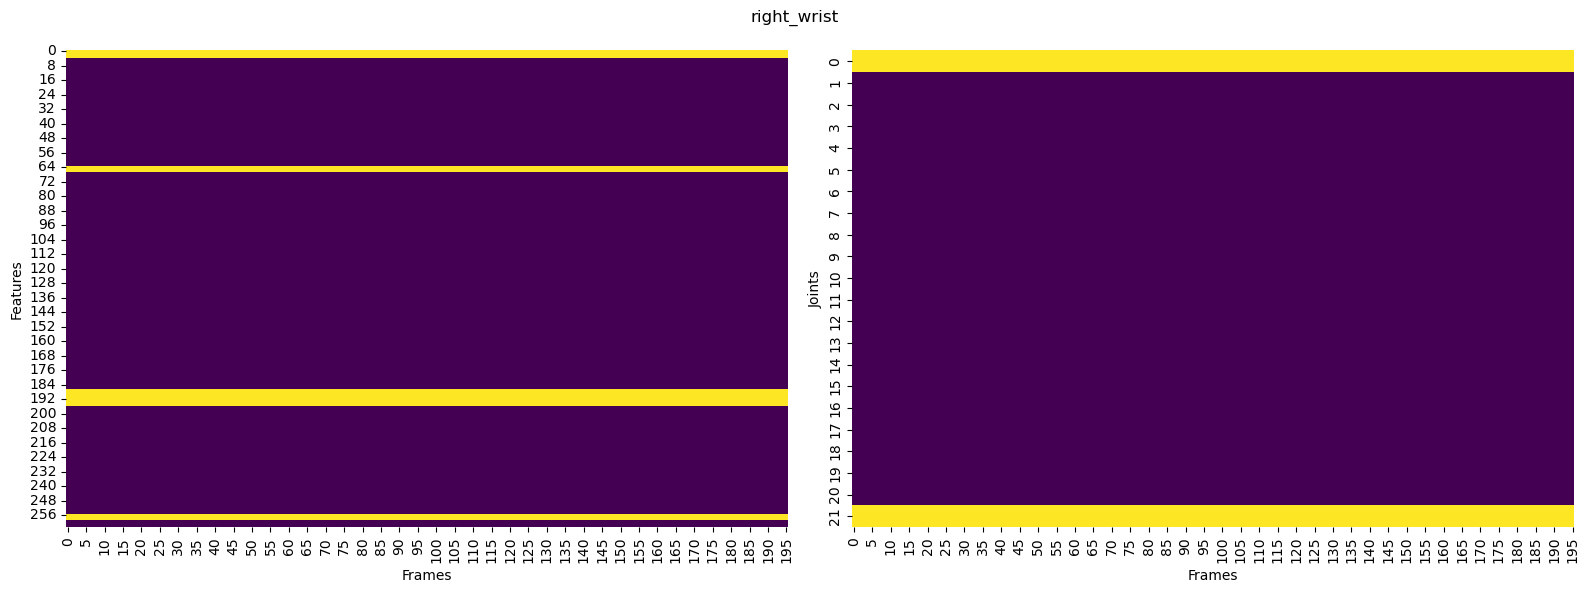

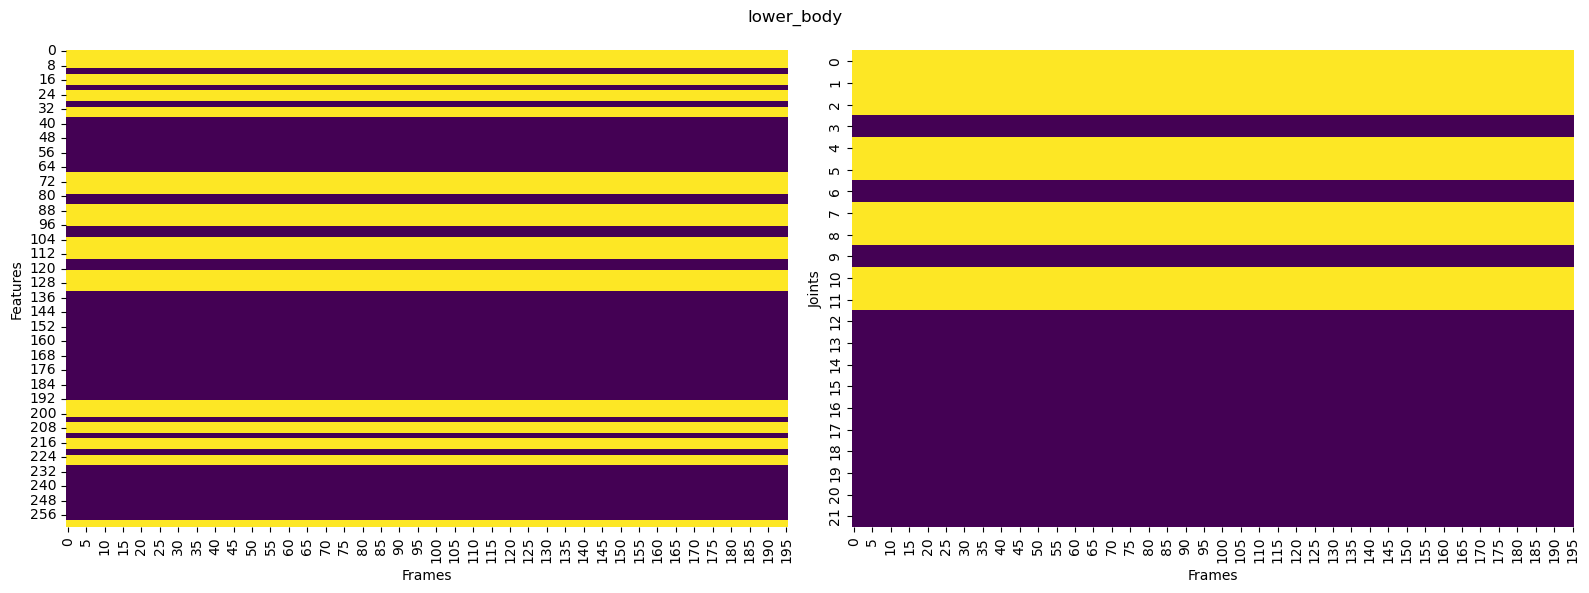

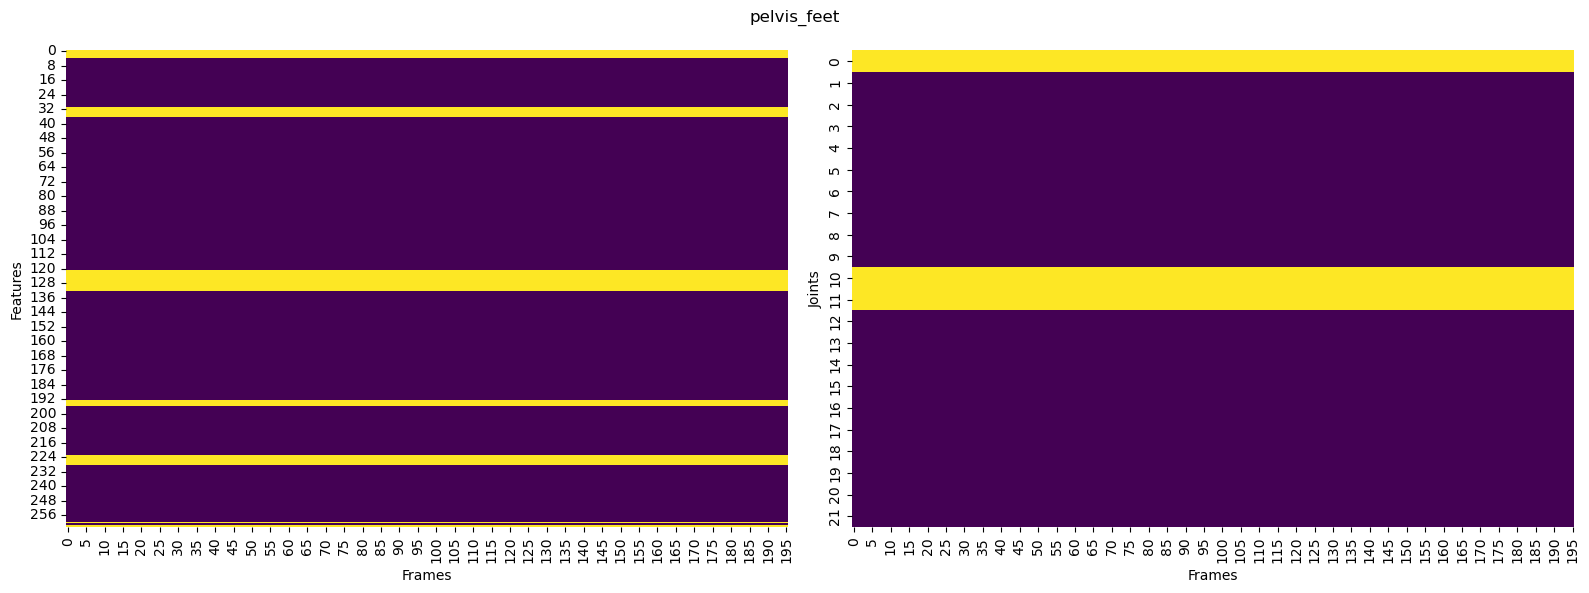

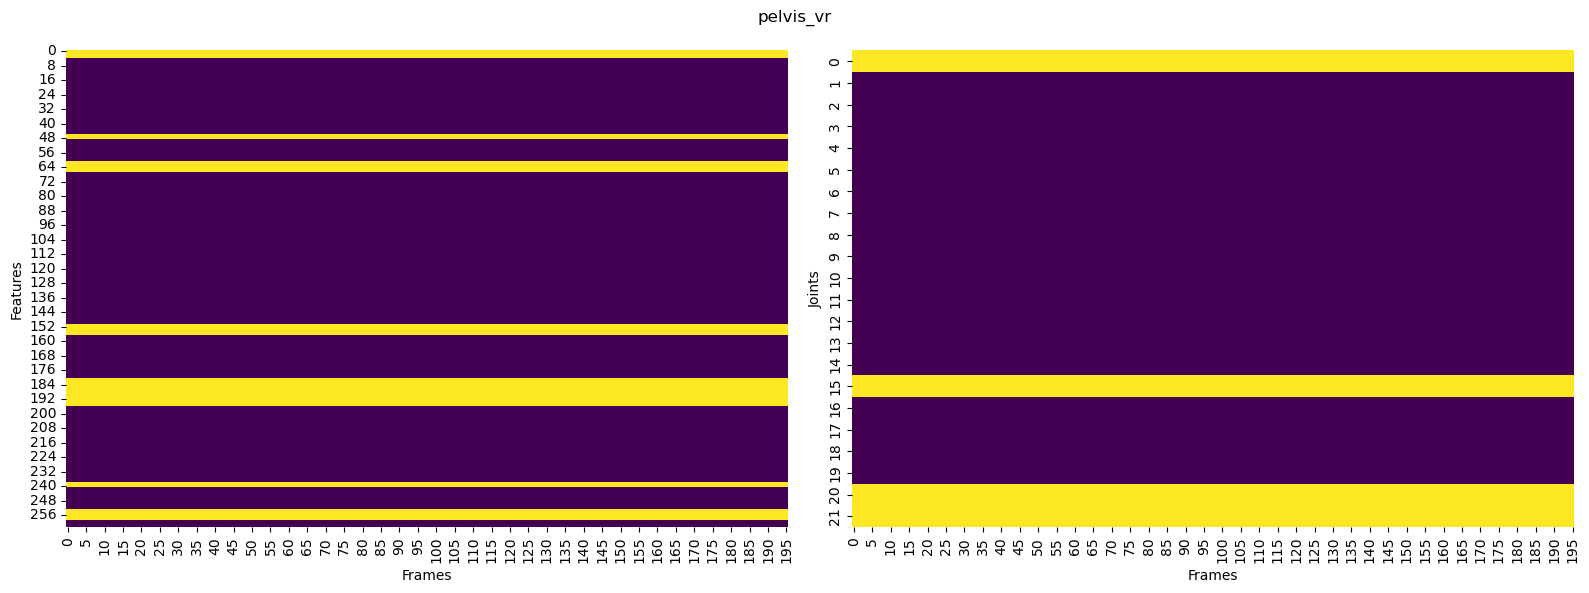

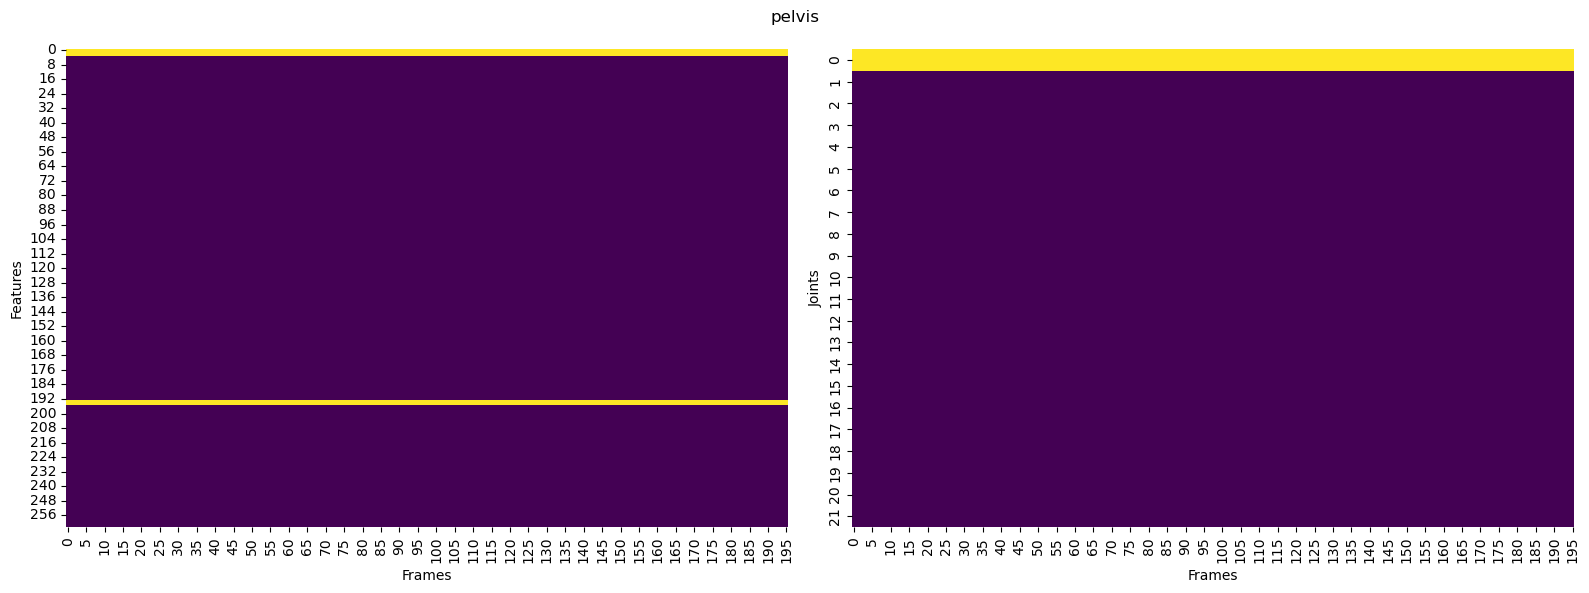

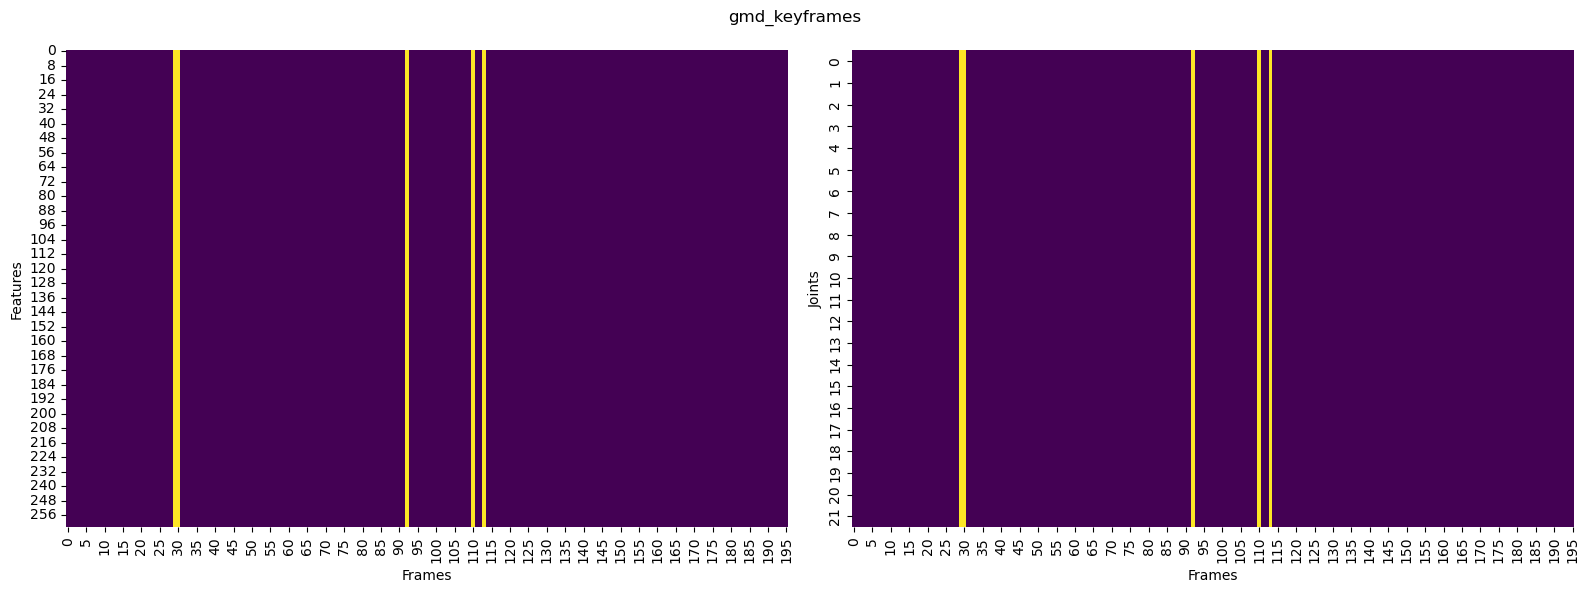

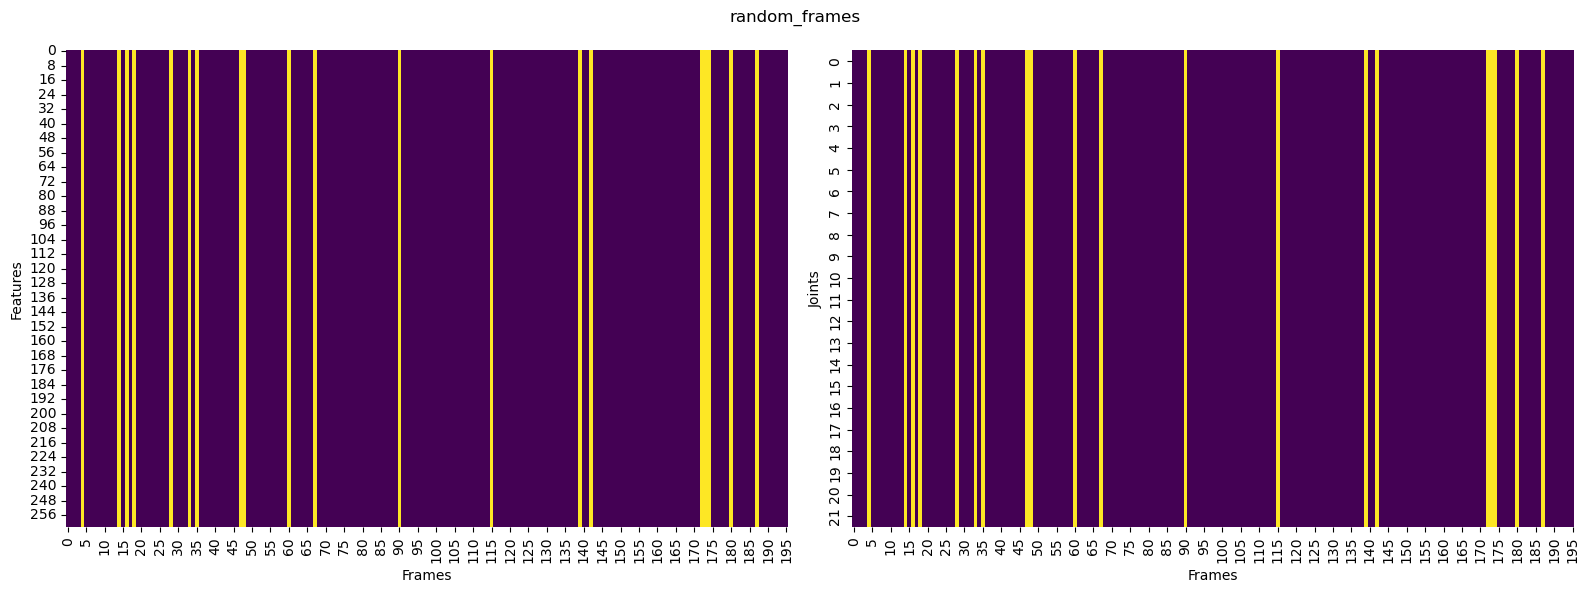

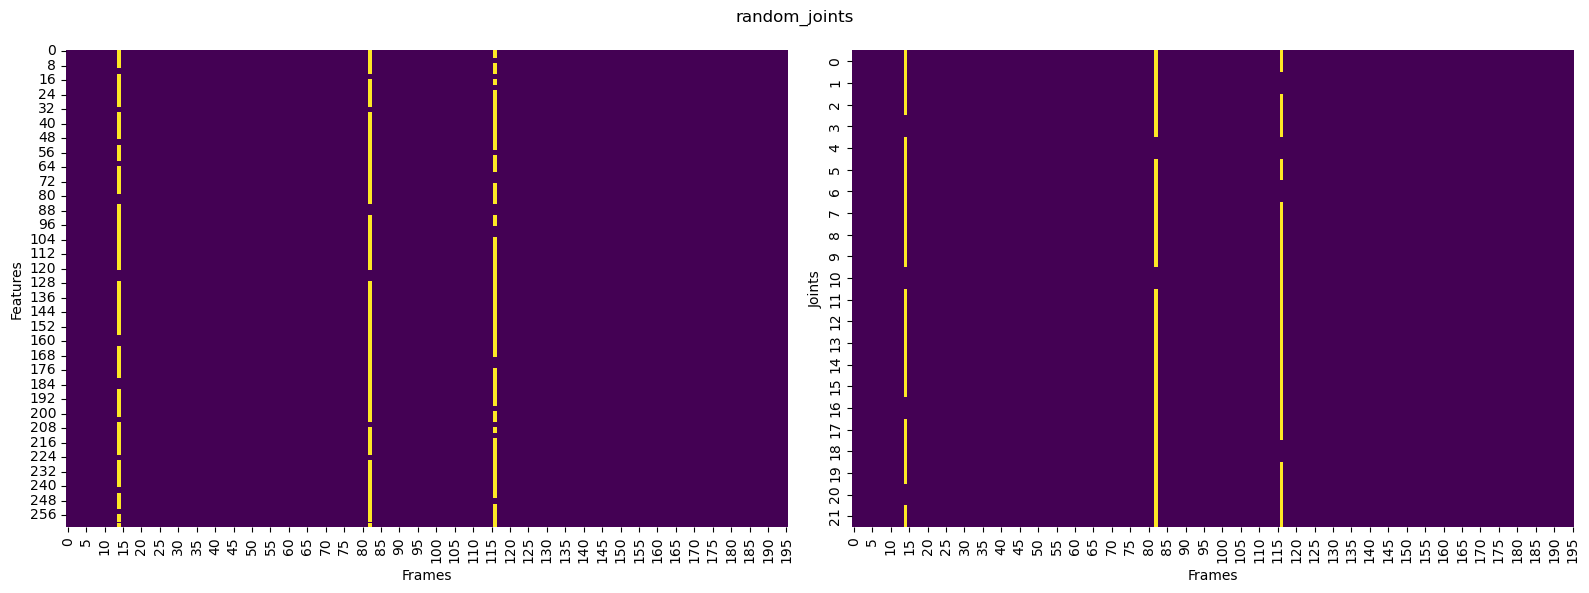

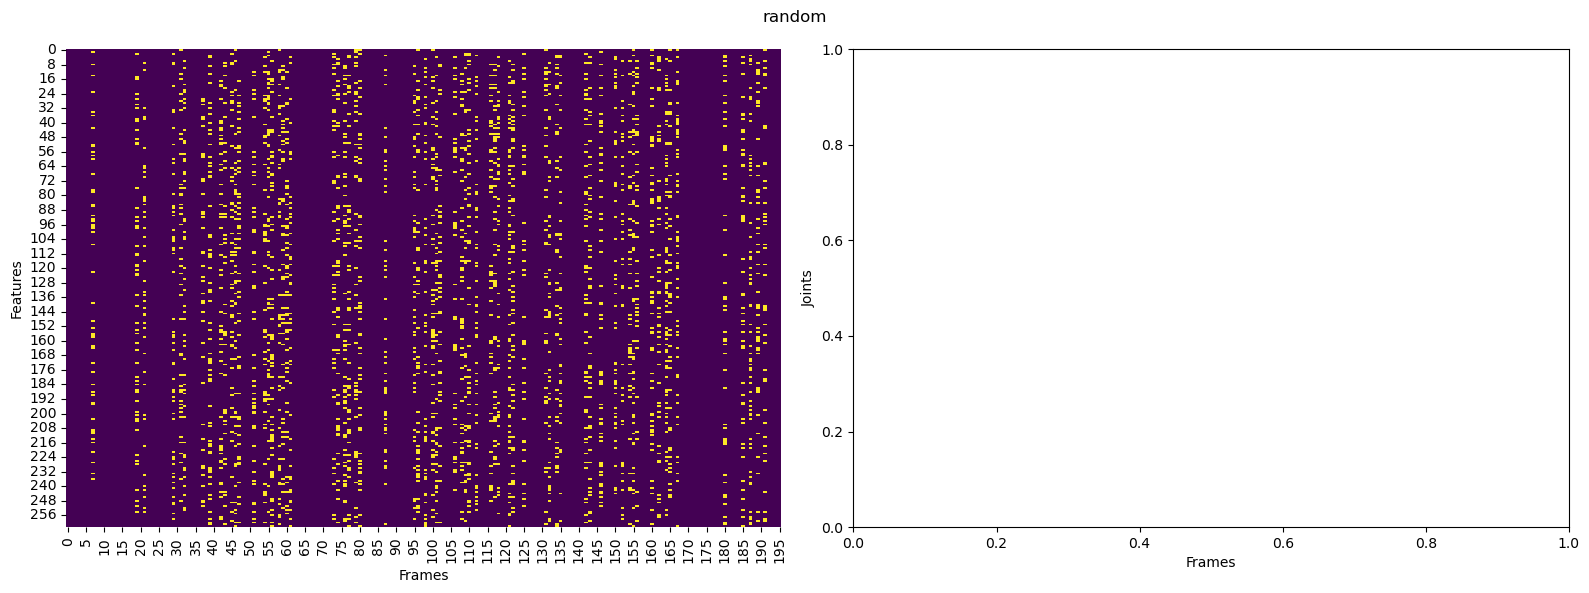

In [31]:
for mode, masks in mode_to_masks.items():
    plot_masks(mode, masks[0], masks[1])


---

## `random_frames` without velocities

**NOTE**: this still contains root xz velocity and root rotational velocity

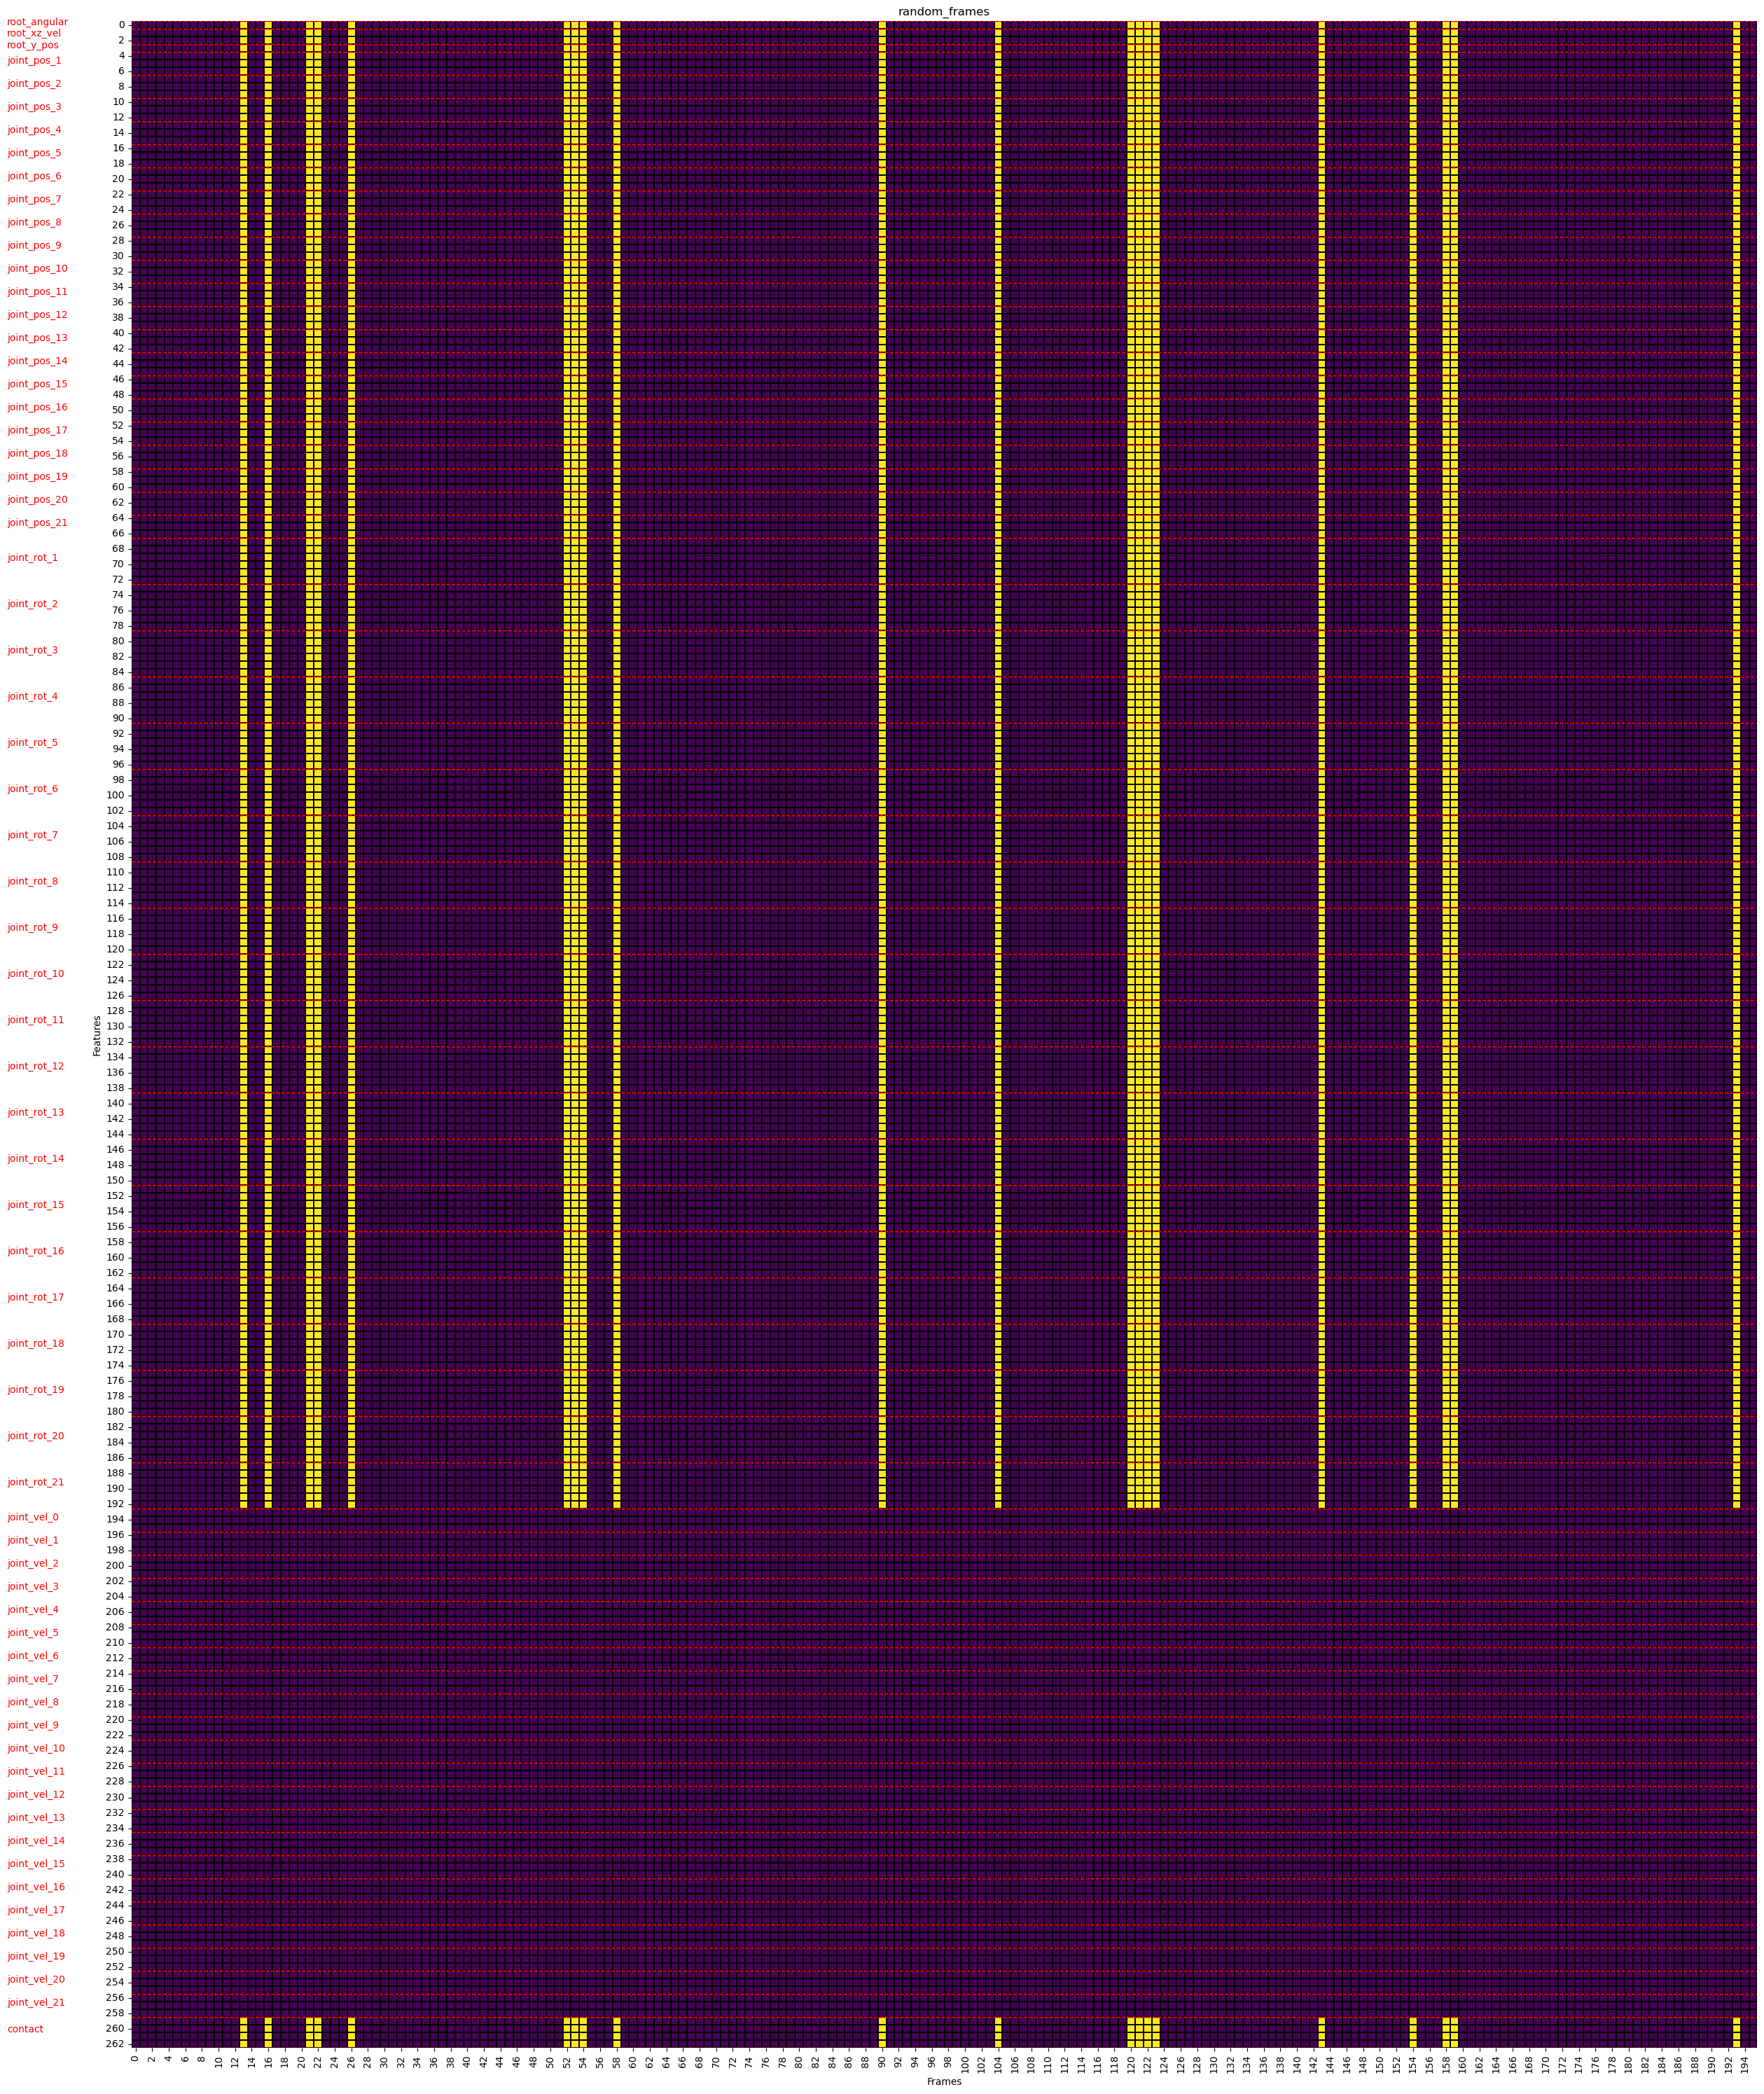

In [35]:
mode = "random_frames"

feat_mask, joint_mask = get_keyframes_mask(
    data=dummy_data,
    lengths=dummy_lengths,
    edit_mode=mode,
    feature_mode="pos_rot",
    get_joint_mask=True,
)

# plot_masks(mode, feat_mask, joint_mask)
plot_mask_sections(mode, feat_mask)